In [1]:
import string
import random
from IPython.display import display, clear_output
from PIL import Image, ImageOps, ImageDraw, ImageFont, ImageChops
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from ipywidgets import interactive, HBox, VBox
from img_processing import preprocess_img, DITHER_MODES
from ascii_art_non_mono_utils import *
from ascii_art_non_mono_algorithms import *
from generate_ascii_palette import *
from ascii_art_conversion_mxn import *
from skimage import metrics

In [2]:
FONT = ImageFont.truetype("fonts/OpenSans-Regular.ttf", 16)
IMG_PATH = "imgs/irad_grad.bmp"

In [3]:
orig_img = Image.open(IMG_PATH).convert("L")
#orig_img = ImageOps.invert(orig_img)

print(orig_img.size)

(512, 512)


In [4]:
def i_preprocess_img(scale_factor, contrast, brightness, quantize_colors, eq, dither):
    proc_img = preprocess_img(orig_img, 0.3, 1.1, 0.5, 0.2, 8, DITHER_MODES.BAYER)
    plt.imshow(proc_img, cmap='gray', vmin=0, vmax=255, interpolation='none')

    plt.figure(figsize=(9, 3))
    plt.xticks([x for x in range(0, len(proc_img.histogram()), 25)])
    plt.bar([x for x in range(0, len(proc_img.histogram()))], proc_img.histogram())
    plt.grid()
    plt.show()

    return proc_img

interactive_preprocess = interactive(i_preprocess_img,
            scale_factor=(0.01, 1, 0.01),
            contrast=(0, 2, 0.01),
            brightness=(0, 2, 0.01),
            eq=(0, 1, 0.01),
            quantize_colors=(1, 256, 1),
            dither=DITHER_MODES)

controls = VBox(interactive_preprocess.children[:-1])
#display(HBox((controls, interactive_preprocess.children[-1])))

In [5]:
proc_img = interactive_preprocess.result

In [6]:
palette = get_asciis()
print(len(palette))
print(palette)

95
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ']


In [7]:
# char_to_brightness_map = generate_non_mono_multi_char_brightness_map(palette, FONT, 3, 3, normalize=True)
# print(len(char_to_brightness_map))

In [8]:
all_lines = split_lines(proc_img, palette, FONT)
print(len(all_lines))
lines = [all_lines[len(all_lines) // 4], all_lines[len(all_lines) // 2], all_lines[-len(all_lines) // 4]]
for l in all_lines:
    display(l)

7


                                      
           <{qN{}{{            
      ~@MMMMMj}      
     <@MMMMMNi      
     <MMMMMMNi      
       >MMMMMN`       
            <>%%<'''          

0.7698634825831159


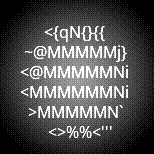

In [9]:
text = greedy_algorithm(proc_img, palette, FONT)
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, FONT)
print(evaluate_text_arr(text, proc_img, FONT))
ImageChops.add(proc_img, bg_img)

4 0.7394313097139682


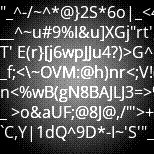

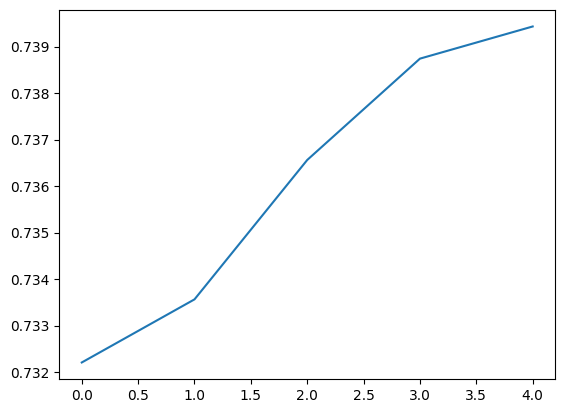

"_^-/~^*@}2S*6o|_<
__^~u#9%I&u]XGj"rt',
T' E(r}[j6wpJJu4?)>G^
_f;<\~OVM:@h)nr<;V!(
n<%wB(gN8BAJLJ3=>%
_ >o&aUF;@8J@,/"'>
`C,Y|1dQ^9D*-I~'S'"_

0.7401987241177463


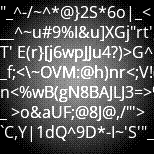

In [10]:
line_finders = [HarmonyLineSearch(line, palette, FONT, 10, 0.9, 0.3, len(palette)//4, False) for line in all_lines]
phs = pool_evolutionary_search(HarmonyLineSearch, line_finders, 20, palette)

res_history = []
for i in range(5):
    text = next(phs)
    clear_output()
    res_history.append(evaluate_text_arr(text, proc_img, FONT))
    print(i, res_history[-1])
    bg_img, draw = new_img_draw(proc_img.size)
    draw_text_arr(draw, text, FONT)
    display(ImageChops.add(proc_img, bg_img))
    plt.plot(res_history)
    plt.show()

for i in range(len(text)):
    text[i] = text[i][:find_end_of_line(text[i], proc_img, FONT)] + '\n'
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, FONT)
print(evaluate_text_arr(text, proc_img, FONT))
ImageChops.add(proc_img, bg_img)

4 0.7541186722622933


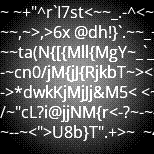

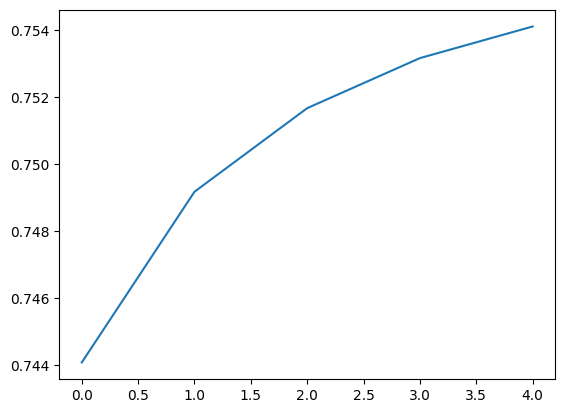

~ ~+"^r`I7st<~~_.-^<
~~,~>,>6x @dh!}`.~~_
~~ta(N{[{Mll{MgY~_`_
-~cn0/jM{jJ{RjkbT~><
->*dwkKjMjJj&M5< <
/~"cL?i@jjNM{r<-?~-~
~--~<">U8b}T".+>~  ~

0.7548176295311513


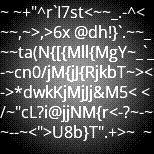

In [11]:
line_finders = [GeneticLineSearch(line, palette, FONT, 100, 0.3, len(palette)//4, False) for line in all_lines]
pgs = pool_evolutionary_search(GeneticLineSearch, line_finders, 20, palette)

res_history = []
for i in range(5):
    text = next(pgs)
    clear_output()
    res_history.append(evaluate_text_arr(text, proc_img, FONT))
    print(i, res_history[-1])
    bg_img, draw = new_img_draw(proc_img.size)
    draw_text_arr(draw, text, FONT)
    display(ImageChops.add(proc_img, bg_img))
    plt.plot(res_history)
    plt.show()

for i in range(len(text)):
    text[i] = text[i][:find_end_of_line(text[i], proc_img, FONT)] + '\n'
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, FONT)
print(evaluate_text_arr(text, proc_img, FONT))
ImageChops.add(proc_img, bg_img)

4 0.7441818049533864


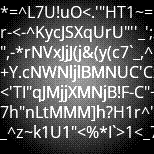

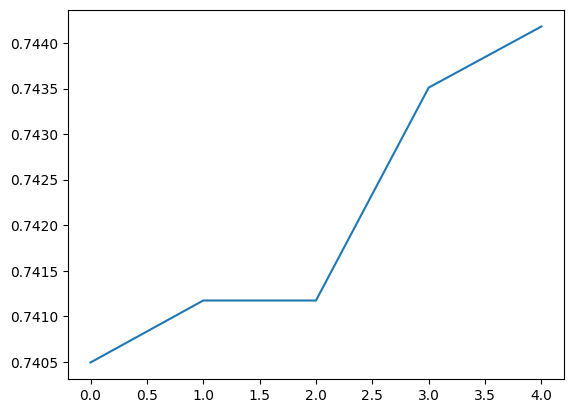

*=^L7U!uO<.'"HT1~=
r-<-^KycJSXqUrU"''_';
",-*rNVxJjJ(j&(y(c7`_,^
+Y.cNWNljlBMNUC'Cx
<'TI"qJMjjXMNjB!F-C"
7h"nLtMMM]h?H1r^
_^z~k1U1"<%*I`>1<_

0.7447517850115253


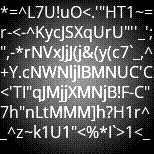

In [12]:

line_finders = [ParticleSwarmLineSearch(line, palette, FONT, 500, 0.3, 2, 1, False) for line in all_lines]
pps = pool_evolutionary_search(ParticleSwarmLineSearch, line_finders, 10, palette)
res_history = []
for i in range(5):
    text = next(pps)
    clear_output()
    res_history.append(evaluate_text_arr(text, proc_img, FONT))
    print(i, res_history[-1])
    bg_img, draw = new_img_draw(proc_img.size)
    draw_text_arr(draw, text, FONT)
    display(ImageChops.add(proc_img, bg_img))
    plt.plot(res_history)
    plt.show()

for i in range(len(text)):
    text[i] = text[i][:find_end_of_line(text[i], proc_img, FONT)] + '\n'
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, FONT)
print(evaluate_text_arr(text, proc_img, FONT))
ImageChops.add(proc_img, bg_img)
